# pymmcore-plus 

##### internship on microscope automation

Contact: Olyssa Sperling (olyssa.sperling@gmx.de) <br/>
Supervisors: Andrew Plested & Thomas Korte <br/>
Field of study: Biophysics <br/>

Outline:
1. device properties & config groups
2. image acquisition: snap images, define and run acquistion sequences, define grid_plan
3. software autofocus
4. stitching of multi-tile images
5. multi-well scan
6. plate calibration

In [1]:
import os
import time
from useq import MDAEvent, MDASequence, Position
from pymmcore_plus.mda import mda_listeners_connected
from pymmcore_plus.mda.handlers import ImageSequenceWriter
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2
import numpy as np
from scipy.optimize import curve_fit
import glob
import pandas as pd
import m2stitch
from os import path

# set micro manager directory
mm_dir = 'D:\ProgramFiles\Micro-Manager-2.0'

# load micro manager system configuration
from pymmcore_plus import CMMCorePlus, Device, DeviceAdapter, ConfigGroup
core = CMMCorePlus()
#core_plus.setDeviceAdapterSearchPaths([mm_dir])
core.loadSystemConfiguration(os.path.join(mm_dir, 'MMConfig_Edge42_SOLA_ASIStage_PixelSize.cfg'))

In [2]:
# set field of view size
f = 1192.8

### 1. device properties & config groups

##### device properties

In [4]:
# camera

core.getCameraDevice()
device = Device('pco_camera', core)
device.properties

(<Property 'pco_camera::Acquiremode' on CMMCorePlus at 0x1f1c511b090: value='Internal'>,
 <Property 'pco_camera::Binning' on CMMCorePlus at 0x1f1c511b090: value=1>,
 <Property 'pco_camera::CCDType' on CMMCorePlus at 0x1f1c511b090: value='max X 2048 - max Y 2048'>,
 <Property 'pco_camera::CameraType' on CMMCorePlus at 0x1f1c511b090: value='pco.edge 4.2 M CLHS rolling shutter - SN:3A2EBCB / Interface: CLHS'>,
 <Property 'pco_camera::DemoMode' on CMMCorePlus at 0x1f1c511b090: value='Off'>,
 <Property 'pco_camera::Description' on CMMCorePlus at 0x1f1c511b090: value='pco.sdk driver module'>,
 <Property 'pco_camera::DotPhoton Filter' on CMMCorePlus at 0x1f1c511b090: value='Off'>,
 <Property 'pco_camera::Exposure' on CMMCorePlus at 0x1f1c511b090: value=199.0>,
 <Property 'pco_camera::Fan/LED: Automatic Fan Control' on CMMCorePlus at 0x1f1c511b090: value='On'>,
 <Property 'pco_camera::Fan/LED: Camera LED' on CMMCorePlus at 0x1f1c511b090: value='On'>,
 <Property 'pco_camera::Fan/LED: Fan Speed 

In [4]:
# xy stage

core.getXYStageDevice()
device = Device('XYStage', core)
device.properties

(<Property 'XYStage::Acceleration-AC(ms)' on CMMCorePlus at 0x1c0f669fae0: value=100>,
 <Property 'XYStage::AxisLetterX' on CMMCorePlus at 0x1c0f669fae0: value='X'>,
 <Property 'XYStage::AxisLetterY' on CMMCorePlus at 0x1c0f669fae0: value='Y'>,
 <Property 'XYStage::Backlash-B' on CMMCorePlus at 0x1c0f669fae0: value=0.04>,
 <Property 'XYStage::BuildName' on CMMCorePlus at 0x1c0f669fae0: value='A2XYZ'>,
 <Property 'XYStage::CompileDate' on CMMCorePlus at 0x1c0f669fae0: value='Apr 07 2017:12:26:13'>,
 <Property 'XYStage::Description' on CMMCorePlus at 0x1c0f669fae0: value='ASI XY stage driver adapter'>,
 <Property 'XYStage::EnableAdvancedProperties' on CMMCorePlus at 0x1c0f669fae0: value='No'>,
 <Property 'XYStage::Error-E(nm)' on CMMCorePlus at 0x1c0f669fae0: value=400.0>,
 <Property 'XYStage::FinishError-PCROS(nm)' on CMMCorePlus at 0x1c0f669fae0: value=24.0>,
 <Property 'XYStage::JoyStick Fast Speed' on CMMCorePlus at 0x1c0f669fae0: value=60>,
 <Property 'XYStage::JoyStick Reverse' on 

In [5]:
# focus

core.getFocusDevice()
device = Device('ZStage', core)
device.properties

(<Property 'ZStage::Acceleration-AC(ms)' on CMMCorePlus at 0x230c9ee1ae0: value=70>,
 <Property 'ZStage::Axis' on CMMCorePlus at 0x230c9ee1ae0: value='Z'>,
 <Property 'ZStage::Backlash-B' on CMMCorePlus at 0x230c9ee1ae0: value=0.01>,
 <Property 'ZStage::BuildName' on CMMCorePlus at 0x230c9ee1ae0: value='A2XYZ'>,
 <Property 'ZStage::CompileDate' on CMMCorePlus at 0x230c9ee1ae0: value='Apr 07 2017:12:26:13'>,
 <Property 'ZStage::Description' on CMMCorePlus at 0x230c9ee1ae0: value='ASI Z-stage driver adapter'>,
 <Property 'ZStage::Error-E(nm)' on CMMCorePlus at 0x230c9ee1ae0: value=200.0>,
 <Property 'ZStage::FinishError-PCROS(nm)' on CMMCorePlus at 0x230c9ee1ae0: value=6.0>,
 <Property 'ZStage::LinearSequenceResetTimeout(ms)' on CMMCorePlus at 0x230c9ee1ae0: value=10000.0>,
 <Property 'ZStage::Maximum Speed (Do Not Change)' on CMMCorePlus at 0x230c9ee1ae0: value=1.92>,
 <Property 'ZStage::MotorOnOff' on CMMCorePlus at 0x230c9ee1ae0: value='On'>,
 <Property 'ZStage::Name' on CMMCorePlus a

In [8]:
core.setFocusDevice('ZStage')
core.initializeDevice('ZStage')

RuntimeError: Device already initialized (or initialization already attempted)

In [6]:
# fluorescence light source

device = Device('LightEngine', core)
device.properties

(<Property 'LightEngine::Connection' on CMMCorePlus at 0x1c0f669fae0: value='COM4'>,
 <Property 'LightEngine::Description' on CMMCorePlus at 0x1c0f669fae0: value='Lumencor Light Engine'>,
 <Property 'LightEngine::LEModel' on CMMCorePlus at 0x1c0f669fae0: value='SOLASE'>,
 <Property 'LightEngine::Model' on CMMCorePlus at 0x1c0f669fae0: value='SOLASE'>,
 <Property 'LightEngine::Name' on CMMCorePlus at 0x1c0f669fae0: value='LightEngine'>,
 <Property 'LightEngine::State' on CMMCorePlus at 0x1c0f669fae0: value=0>,
 <Property 'LightEngine::WHITE' on CMMCorePlus at 0x1c0f669fae0: value=0>,
 <Property 'LightEngine::WHITE_Intensity' on CMMCorePlus at 0x1c0f669fae0: value=0>)

##### config groups

In [5]:
core.getConfigGroupObject('LED_light')

ConfigGroup(presets=['off', 'on'], n_properties=1)

In [6]:
core.getConfigGroupObject('fluorescence')

ConfigGroup(presets=['off', 'on_50P', 'on_70P'], n_properties=3)

### 5. multi-well scan

In [26]:
z = -1867.7

six_well_pos = [(20000, 40000, z), # A1
                (20000, 0, z), # A2
                (20000, -40000, z), # A3
                (-20000, 40000, z), # B1
                (-20000, 0, z), # B2
                (-20000, -40000, z) # B3
                ]

writer = ImageSequenceWriter(r'C:\Users\Admin\Desktop\focus', extension=".png", overwrite=True)

In [32]:
core.setRelativeXYPosition(0, 80000)

In [132]:
sequence = MDASequence(
    #axis_order = "tpgcz",
    stage_positions = [six_well_pos[0]],
    grid_plan = {'rows': 4, 'columns': 4, 
                 'relative_to': 'center',
                 'overlap': 20,
                 'mode': 'row_wise',
                 'fov_width': f,
                 'fov_height': f},
    channels = [{'group': 'LED_light', 'config': 'on'}]
)

2024-08-14 17:08:24,545 - pymmcore-plus - INFO - (_runner.py:321) MDA Started: stage_positions=(Position(x=20000.0, y=40000.0, z=-1867.7, name=None, sequence=None),) grid_plan=GridRowsColumns(fov_width=1192.7552, fov_height=1192.7552, overlap=(20.0, 20.0), mode=<OrderMode.row_wise: 'row_wise'>, rows=4, columns=4, relative_to=<RelativeTo.center: 'center'>) channels=(Channel(config='on', group='LED_light', exposure=None, do_stack=True, z_offset=0.0, acquire_every=1, camera=None),)
2024-08-14 17:08:24,549 - pymmcore-plus - INFO - (_runner.py:283) index=mappingproxy({'p': 0, 'g': 0, 'c': 0}) channel=Channel(config='on', group='LED_light') x_pos=18568.693760000002 y_pos=41431.30624 z_pos=-1867.7
2024-08-14 17:08:25,582 - pymmcore-plus - INFO - (_runner.py:283) index=mappingproxy({'p': 0, 'g': 1, 'c': 0}) channel=Channel(config='on', group='LED_light') x_pos=19522.89792 y_pos=41431.30624 z_pos=-1867.7
2024-08-14 17:08:26,398 - pymmcore-plus - INFO - (_runner.py:283) index=mappingproxy({'p': 

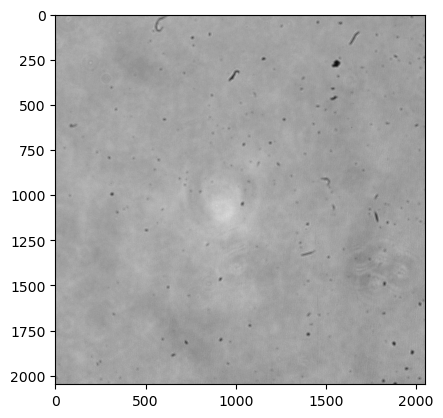

In [133]:
with mda_listeners_connected(writer):
    core.mda.run(sequence)
    
core.snapImage()
im = core.getImage()

core.setConfig('LED_light', 'off')

plt.imshow(im, cmap='gray')

In [134]:
cross_images = glob.glob(r'C:\Users\Admin\Desktop\focus\*.png')
len(cross_images)

16

In [135]:
images = np.stack([cv2.imread(file) for file in cross_images],
                  axis=0)
images_squeezed = images[:, :, :, 1]
images_squeezed.shape

(16, 2048, 2048)

In [138]:
result_df, _ = m2stitch.stitch_images(
    images_squeezed, r, c, 
    row_col_transpose=False,
    ncc_threshold=0.0001
)

100%|██████████| 16/16 [00:07<00:00,  2.20it/s]


In [141]:
images = images_squeezed

# stitching example
result_df["y_pos2"] = result_df["y_pos"] - result_df["y_pos"].min()
result_df["x_pos2"] = result_df["x_pos"] - result_df["x_pos"].min()

size_y = images.shape[1]
size_x = images.shape[2]

stitched_image_size = (
    result_df["y_pos2"].max() + size_y,
    result_df["x_pos2"].max() + size_x,
)
stitched_image = np.zeros_like(images, shape=stitched_image_size)
for i, row in result_df.iterrows():
    stitched_image[
        row["y_pos2"] : row["y_pos2"] + size_y,
        row["x_pos2"] : row["x_pos2"] + size_x,
    ] = images[i]

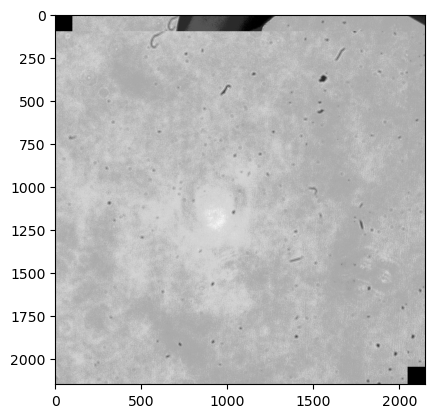

In [142]:
plt.imshow(stitched_image, cmap='grey')

### 6. plate calibration